## Part 3 - Multi- or N-dimensional datasets

Multi- or N-dimensional geospatial data refers to datasets that include multiple layers or dimensions of geographical information. This data goes beyond the simple two-dimensional latitude and longitude (or y and x) coordinates we have seen in the earlier notebooks and often includes additional dimensions such as time, elevation (altitude or depth), and other variables like temperature, humidity, rainfall.

Additional resources can be found throughout the notebook.

In [ ]:
# ONLY NEEDS TO BE RUN IF USING GOOGLE COLABS
%%capture
!pip install s3fs cartopy zarr boto3 netcdf4 rasterio

In [ ]:
import os
import s3fs
import boto3
import xarray as xr
import numpy as np
import cartopy as cp
import geopandas as gpd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime
import zarr

In this notebook we will explore how to work with gridded N-dimensional datasets stored remotely. Specifically we will be looking at datasets stored as [Zarr](https://zarr.dev/), which is a format becoming increasingly common in big-data science where datasets need to be stored in remote "object stores" due to their size.

[NetCDF](https://www.unidata.ucar.edu/software/netcdf/) is another very common format for gridded N-dimensional datasets. Whilst we will not explicitly work with NetCDF data here, once data is read into [Xarray](https://docs.xarray.dev/en/stable/) it behaves in the same way and the same commands can be used.

### Access and explore the datasets in object store buckets (using FSSpec and Xarray)

We will be working with an hourly gridded rainfall dataset - [UKCEH GEAR](https://catalogue.ceh.ac.uk/documents/fc9423d6-3d54-467f-bb2b-fc7357a3941f)

For publically available data such as this, we do not need any credentials, and instead pass ```anon=True``` which means 'access the data as an anonymous user'.

We will use the [FSSpec](https://filesystem-spec.readthedocs.io/en/latest/) package, which basically has the ability to take any data stored on any storage system and make it look as if the data is on an ordinary disk to the rest of your code. The idea is that you run this bit of code once and then it gets out the way and lets you continue your coding as if the data was still on disk and not in a remote object store in the cloud.

To make it work we provide ```anon=True``` and the ```endpoint_url```, but also the path to the specific dataset we want to use:

**Note:** There are two ways of doing this, depending on which version of the Zarr package is installed in your python environment. To check, run:

In [ ]:
zarr.__version__

'3.1.5'

In [ ]:
# zarr v2 method
#zstore = fsspec.get_mapper('s3://gearhrly/gearhrly_fulloutput_yearly_100km_chunks.zarr',
#                           anon=True,
#                           endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")

# zarr v3 method
fs = s3fs.S3FileSystem(anon=True, asynchronous=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")
zstore = zarr.storage.FsspecStore(fs, path="gearhrly/gearhrly_15day_100km_chunks.zarr")

We then pass the created file-system-like object to Xarray, and from here on in Xarray behaves as if the data were stored locally on disk, and we can largely forget about the fact that it's actually stored remotely in the cloud.

In [ ]:
ds = xr.open_zarr(zstore, consolidated=True)

Next let's explore the dataset a bit.

In [ ]:
ds

<xarray.Dataset> Size: 5TB
Dimensions:          (time: 236688, y: 1251, x: 701, bnds: 2)
Coordinates:
  * time             (time) datetime64[ns] 2MB 1990-01-01 ... 2016-12-31T23:0...
  * y                (y) float64 10kB 1.25e+06 1.249e+06 1.248e+06 ... 1e+03 0.0
  * x                (x) float64 6kB 0.0 1e+03 2e+03 ... 6.98e+05 6.99e+05 7e+05
    crs              int16 2B ...
    lat              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    time_bnds        (time, bnds) datetime64[ns] 4MB dask.array<chunksize=(360, 2), meta=np.ndarray>
    x_bnds           (x, bnds) float64 11kB dask.array<chunksize=(100, 2), meta=np.ndarray>
    y_bnds           (y, bnds) float64 20kB dask.array<chunksize=(100, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    min_dist         (time, y, x) float64 2TB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 2TB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
    stat_disag       (time, y, x) float64 2TB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
Attributes: (12/29)
    Conventions:                   CF-1.6
    acknowledgement:               This research forms part of the SINATRA pr...
    cdm_data_type:                 Grid
    contributor_name:              Lewis, E., Quinn, N., Blenkinsop, S., Fowl...
    creator_email:                 enquiries@ceh.ac.uk
    creator_institution:           UK Centre for Ecology & Hydrology (UKCEH)
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v70, http://cfconve...
    summary:                       The CEH-GEAR1hr-v2 dataset contains 1-km g...
    time_coverage_duration:        P27Y
    time_coverage_resolution:      P1H
    title:                         Gridded estimates of hourly areal rainfall...
    version:                       v2

The variables in the dataset are split into those that describe the coordinates, and those of the main data. We can see the three main data variables: 'min_dist', 'rainfall_amount' and 'stat_disag', you can click the page icon at the end of each variable's row to find out a little more about each.

The names in brackets next to the variable names (the second column of information) show you the dimensions that each variable is on. Here, all our data variables are on a 3D grid of time, y and x.

You can see in the Coordinates section that we have other coordinates besides those for the time, y and x dimensions. The lat and lon variables tell you the latitude and longitude conversion for each x,y gridpoint and the 'xxx_bnds' variables tell you the extent/valid range of each datapoint. So for example a gridpoint of (6000,6000) on a grid with a resolution of (1000,1000) would have extents/boundaries of (5500,6500) for both x and y, describing the extent of the gridbox this gridpoint represents. The same concept can be extended to the time-dimension too.

More information about the dataset is available by clicking on 'Attributes' to expand this section

All Zarr datasets that follow the [CF-Conventions](https://cfconventions.org/) (a format standard for NetCDF, and Zarr by extension, originally created for climate-model data but slowly being expanded out to cover more disciplines in the geosciences) should look similar to this one.

Variables are selected using ```datasetname['variablename']```

The ```.data``` attribute pulls out the underlying data array of the specified variable, which in the case of Zarr will be a Dask array. Dask arrays, as opposed to standard Numpy arrays you might be used to working with, are 'chunked' into little parcels of data. It's a feature of the format that makes it most suitable for storage on the cloud.

In [ ]:
ds['rainfall_amount'].data

dask.array<open_dataset-rainfall_amount, shape=(236688, 1251, 701), dtype=float64, chunksize=(360, 100, 100), chunktype=numpy.ndarray>

- **Bytes** shows you the overall size of the array and indivdual chunk
- **Shape** shows you the dimension sizes of the array and chunk. This dataset has 236688 time steps!
- **Dask graph** tells you how many tasks (68432 here) would be needed to load the actual data into memory (see below section on Lazy Loading)
- **Data type** tells you what the data inside the array consists of. Here it is a Numpy array containing 64-bit (8-byte) floats (floating-point numbers), which is typical for numeric data.

### Computations and visualisations with Xarray and Dask

#### An introduction to Lazy Loading

Before we go any further it is very important to know that Xarray loads data *lazily*. This means that the actual data is never loaded or computed until it absolutely has to be. So you may run some code that computes the mean of the dataset (e.g. ```dmean = ds['variable'].mean(dim='time')```), but the calculation will only actually be carried out when you want to *see* the result of this calculation, e.g. through a plot or print statement, or saving to disk.

This means just running the line ```dmean = ds['variable'].mean(dim='time')``` would be very fast, but trying to plot the result will trigger the calculation and take much longer.

[Dask](https://www.dask.org/) also takes this a step further. Dask is a library designed to automatically parallelise computations; parallelisation is essential when dealing with chunked data such as Zarr on the cloud. Dask sits in the background working out how best to parallelise your computations, then whenever Xarray actually triggers a compute, Dask will automatically kick in and process the computation in parallel. However, with Dask, the *output* of the computation will not persist in memory, even if you save the output to a variable (e.g. ```dmean = ds['variable'].mean(dim='time')```). If you run the code again, Dask will *recompute* everything from scratch, the actual data is not stored in the variable ```dmean```, rather the Dask-instructions for computing it. This can make code very slow if not handled correctly. The best way to handle this is to make use of Dask's [```.persist()```](https://distributed.dask.org/en/latest/api.html?highlight=persist#distributed.Client.persist)and [```.compute()```](https://docs.dask.org/en/stable/api.html?highlight=compute#dask.compute) methods. Appending this on to the end of a calculation, such as ```dmean = ds['variable'].mean(dim='time').compute()``` will keep the data in memory.

The main difference between [```persist```](https://distributed.dask.org/en/latest/api.html?highlight=persist#distributed.Client.persist) and [```compute```](https://docs.dask.org/en/stable/api.html?highlight=compute#dask.compute) is that [```persist```](https://distributed.dask.org/en/latest/api.html?highlight=persist#distributed.Client.persist) will allow you to continue coding whilst dask computes the result in the background, whereas [```compute```](https://docs.dask.org/en/stable/api.html?highlight=compute#dask.compute) will wait until the computation is complete before letting you continue coding. [```compute```](https://docs.dask.org/en/stable/api.html?highlight=compute#dask.compute) generally behaves the most intuitively and is the preferred option.

#### Plot an individual time step

Let's take a look at plotting the data.

You can index the array and pull out a single timestep like you can any standard array-like object in Python, in this instace we're looking at the 37th time step, indicated by ```[36,:,:]```.

Xarray also adds a ```plot()``` method you can call to produce a rough-and-ready quick plot of the data you've selected, in this case the 37th timestep of the dataset.

[########################################] | 100% Completed | 76.91 s


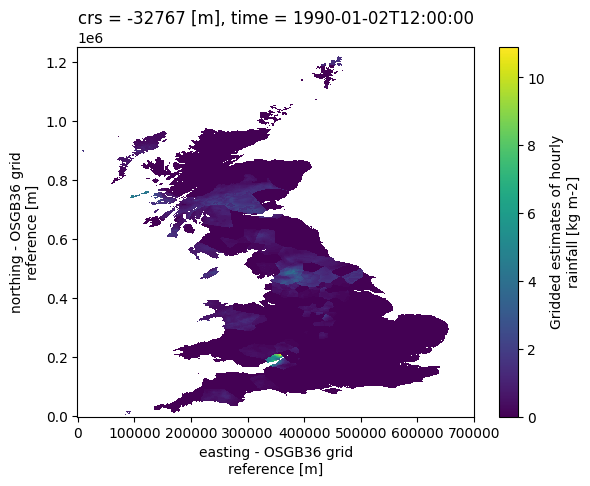

In [ ]:
with ProgressBar():
    ds['rainfall_amount'][36,:,:].plot()

#### Customising plots

These plots can be customised to look nicer too. Here we're making use of Dask's [```compute()```](https://docs.dask.org/en/stable/api.html?highlight=compute#dask.compute) method to save the variable ```plotpoint``` in memory, so that we don't have to rerun the processing needed to extract this point from the cloud whenever we rerun the plotting commands:

In [ ]:
with ProgressBar():
    plotpoint = ds['rainfall_amount'][36,:,:].compute()

[########################################] | 100% Completed | 71.88 s


Text(0.5, 1.0, 'Rainfall $2^{nd}$ Jan 1990 12:00')

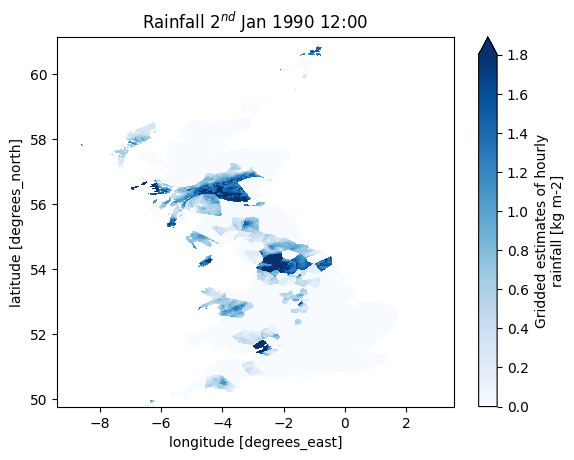

In [ ]:
plotpoint.plot.pcolormesh('lon', 'lat', cmap='Blues', robust=True)
plt.title(r'Rainfall $2^{nd}$ Jan 1990 12:00')

Here we have:
- changed the axes to use lon/lat instead of x/y coordinates by specifying the dataset name of the longitude and latitude variables in the plotting command
- changed the colourmap to a nicer one (all pre-built colourmaps can be found at https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
- changed the title to better describe the data being plotted
- used Xarray's 'robust' option, which modifies the colourbar to not stretch to the maximum of the data if it is an outlier. This stops a small area of very high values dominating the colourbar and making other variation invisible

The "Blues" colourmap uses white for the low end of the scale, making it hard to see the shape of the UK now. It would also be nice to have some coastlines. For this we have to go beyond what Xarray's built-in plotting can acheive and use the Cartopy package:

In [ ]:
import cartopy.crs as ccrs # the set of map projections cartopy supports
import cartopy as cp # the full cartopy package

Passing the ```projection``` 'key-word argument' to the plotting function tells the plotting library to invoke cartopy to draw the plot using a given map projection. Here we are using the 'OSGB' map projection (a cartesian grid, in other words a flat plane approximation that ignores the curvature of the earth) which a lot of UK hydrological data will be on. For any data that is on a 'lon/lat' grid instead of an 'x/y' grid, the [```ccrs.PlateCarree()```](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#platecarree) projection is a better option.

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


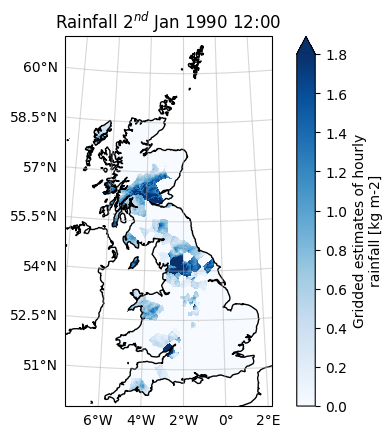

In [ ]:
plot1 = plotpoint.plot.pcolormesh(cmap='Blues', robust=True, subplot_kws=dict(projection=ccrs.OSGB())) # create the initial plot
plt.title(r'Rainfall $2^{nd}$ Jan 1990 12:00')
plot1.axes.coastlines() # add coastlines
gl = plot1.axes.gridlines(draw_labels=True, alpha=0.5) # add gridlines. The alpha parameter is the transparency between 0 and 1.
gl.top_labels = False
gl.right_labels = False # remove the top and right gridlines labels to make the plot look nicer

## Further Resources

- [Xarray documentation](https://docs.xarray.dev/en/stable/)
- [Xarray "common usage patterns" tutorial](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html)
- [Dask documentation](https://docs.dask.org/en/stable/index.html)
- [Dask tutorial](https://ncar.github.io/dask-tutorial/notebooks/00-dask-overview.html)
- [FSSpec documentation](https://filesystem-spec.readthedocs.io/en/latest/)
- [Pangeo tutorial gallery](https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/index.html)

# Supplementary

#### Climatology

We can also do things such as computing the monthly climatology. This takes a while to compute using the in-built default dask setup, so this is more "something for you to try at home". It is best to run it once and save it to disk so that it can be loaded in when you next want to access it.

You only need to run the next cell if you want to generate the 'gear1hrly_climatology.nc' file yourself. It takes a very long time to run.

In [ ]:
'''
with ProgressBar():
    monthlyavg = ds['rainfall_amount'].groupby('time.month').mean()
    climo = monthlyavg.compute()

climo.to_netcdf('gear1hrly_climatology.nc')
'''

Otherwise you can just load it in like you would any netcdf dataset, either from disk, if that's where you've saved it:

In [ ]:
'''
climo = xr.open_dataarray('gear1hrly_climatology.nc')
'''

For now we can load this data from object storage where a copy is saved:

In [ ]:
fs_climo = s3fs.S3FileSystem(endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk", anon=True) # or anon=False to use default credentials
climo = xr.open_dataset(fs_climo.open('example-data/gear1hrly_climatology.nc', 'rb'), engine='h5netcdf')

In [ ]:
climo

<xarray.Dataset> Size: 98MB
Dimensions:          (month: 12, y: 1251, x: 701)
Coordinates:
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * y                (y) float64 10kB 1.25e+06 1.249e+06 1.248e+06 ... 1e+03 0.0
  * x                (x) float64 6kB 0.0 1e+03 2e+03 ... 6.98e+05 6.99e+05 7e+05
    crs              int16 2B ...
    lat              (y, x) float64 7MB ...
    lon              (y, x) float64 7MB ...
Data variables:
    rainfall_amount  (month, y, x) float64 84MB ...

Once again we can easily produce a quick plot of the data, in this case the 2nd month of the climatology:

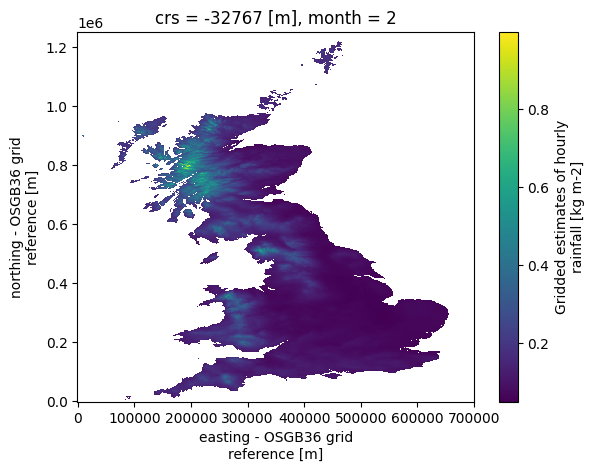

In [ ]:
climo['rainfall_amount'][1,:,:].plot()

We can also produce a plot comparing two different months

Here we use matplotlib directly here to create a nicer looking plot.

First of all we set up the figure to contain 2 plots, then it's a case of creating the nicer plot as we did earlier. The only difference we need to make is to manually handle the colourbar ourselves, otherwise matplotlib will plot two identical colourbars. Therefore we create a third set of axes to hold the colourbar in a position we define and set the min and max ourselves too.

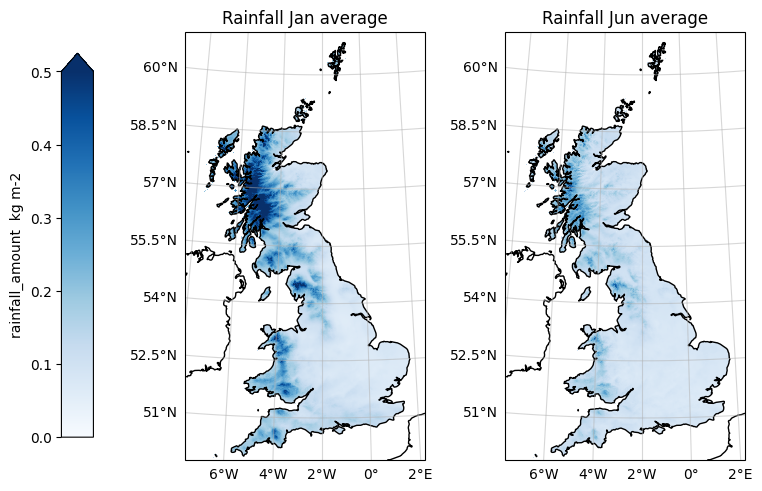

In [ ]:
colmap='Blues' # colour map to use, see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
vmin=0 # lower colourmap boundary of all plots (the colourbar needs to be the same across all plots to enable an easy comparison)
vmax=0.5 # upper colourmap boundary of all plots

fig, axs = plt.subplots(ncols=2, constrained_layout=True, subplot_kw=dict(projection=ccrs.OSGB()))
ax1 = axs[0]
ax2 = axs[1]

# extract out x and y coordinates
xs = climo['x'].values
ys = climo['y'].values

plot1 = ax1.pcolormesh(xs, ys, climo['rainfall_amount'][0,:,:].values, vmin=vmin, vmax=vmax, cmap=colmap)
plot2 = ax2.pcolormesh(xs, ys, climo['rainfall_amount'][5,:,:].values, vmin=vmin, vmax=vmax, cmap=colmap)

# manually create a colourbar to the left of the main plot
cbaxes=fig.add_axes([-0.1, 0.1, 0.05, 0.8])
plt.colorbar(plot1, cax=cbaxes, extend='max') # extend the upper limit of the colourbar to make clear any values higher than it are the same colour
cbaxes.yaxis.set_label_position("left") # set the colourbar label position...
cbaxes.yaxis.tick_left() # ...and tickmarks
# set the ylabel of the colourbar to the xarray dataarray name and failing that, leave it blank
try:
    plotlab = climo['rainfall_amount'].name + '  ' + climo['rainfall_amount'].units
except AttributeError:
    plotlab = ''
cbaxes.set_ylabel(plotlab)

ax1.set_title('Rainfall Jan average')
ax2.set_title('Rainfall Jun average')
ax1.axes.coastlines() # add coastlines
ax2.axes.coastlines() # add coastlines
gl1 = plot1.axes.gridlines(draw_labels=True, alpha=0.5) # add gridlines. The alpha parameter is the transparency between 0 and 1.
gl2 = plot2.axes.gridlines(draw_labels=True, alpha=0.5) # add gridlines. The alpha parameter is the transparency between 0 and 1.
gl1.top_labels = False
gl1.right_labels = False
gl2.top_labels = False
gl2.right_labels = False # remove the top and right gridlines labels to make the plot look nicer

We can also select out a particular gridpoint to view the climatology there by using the ```.sel()``` function:

In [ ]:
climo['rainfall_amount'].sel(x=275000, y=300000).plot()

We could also compare this to a different gridpoint:

In [ ]:
climopoint1 = climo['rainfall_amount'].sel(x=275000, y=300000)
climopoint2 = climo['rainfall_amount'].sel(x=450000, y=200000)

point1 = climopoint1.plot()
ax1 = plt.gca()
point2 = climopoint2.plot(ax=ax1)

point1[0].set_label('275000, 300000')
point2[0].set_label('450000, 200000')
plt.legend()
plt.title('Climatology of two grid points')

### Catchment Extraction

Or "Subsetting gridded data using a shapefile"

Let's now combine some of the datatypes we've been talking about. Specifically, NetCDF/Zarr and shapefiles.

**Note:** This section uses some functions that were written(/heavily copied from stackoverflow) by a UKCEH colleague and that exist in a python script *utilities.py* in the repo this notebook was obtained from. To use these functions you will also have to have this script in the same folder as this notebook. We can obtain it using ```wget```:

In [1]:
!wget https://github.com/NERC-CEH/ghana_hydro_training_2026/raw/refs/heads/main/Day1_Hydrological_Datasets/utils.py

--2026-01-21 11:13:40--  https://github.com/NERC-CEH/ghana_hydro_training_2026/raw/refs/heads/main/Day1_Hydrological_Datasets/utils.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/refs/heads/main/Day1_Hydrological_Datasets/utils.py [following]
--2026-01-21 11:13:41--  https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/refs/heads/main/Day1_Hydrological_Datasets/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20987 (20K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  20.50K  --.-KB/s    in 0.004s 

In [ ]:
from utils import *

First let's load in the climatology we saved earlier:

In [ ]:
fs_climo = s3fs.S3FileSystem(endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk", anon=True) # or anon=False to use default credentials

climo = xr.open_dataset(fs_climo.open('example-data/gear1hrly_climatology.nc'), engine='h5netcdf')
print(climo)

And have a look at the shapefile we're going to be using to subset the data using Geopandas.

In [ ]:
sfname = 's3://example-data/gb_catchments.zip'
fs_shp = s3fs.S3FileSystem(anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")
sfile = gpd.read_file(fs_shp.open(sfname))

In [ ]:
sfile

Remember each shape in the shapefile is represented by a row in the table, and the metadata associated with each shape by the columns. The geometry column is the special case, and the main difference between the standard Pandas library and Geopandas. This column contains the vector information that describes the actual shape.

We can use the subsetting script to cut out a piece of our dataset according to one or more shapes in the shapefile:

This is the convenience function I've developed to ease the process. Put a question mark after a given function, to see more information about it:

In [ ]:
catchment_subset_shapefile?

In [ ]:
climo39001 = catchment_subset_shapefile(data=climo, sfname=sfname,
                                        endpoint="https://fdri-o.s3-ext.jc.rl.ac.uk",
                                        IDname='ID_STRING', IDs=['39001'], drop=1)

In [ ]:
climo39001

In [ ]:
climo39001_jan = climo39001['rainfall_amount'][0,:,:]

In [ ]:
climo39001_jan.plot()

Now like before let's make the plot a bit better, this time adding in the border of the catchment we've extracted:

Read in the shapefile with Geopandas:

In [ ]:
sfname = 's3://example-data/gb_catchments.zip'
fs_shp = s3fs.S3FileSystem(anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")
shapefile = gpd.read_file(fs_shp.open(sfname))
shapefile = shapefile.set_index('ID_STRING')

Extract out the same catchment that we used earlier:

In [ ]:
cat39001 = sfile.where(sfile['ID_STRING']=='39001').dropna()

Create the plot:

In [ ]:
gbax = plt.axes(projection=cp.crs.OSGB()) # create the (geo) axes for the plot
cat39001.plot(ax=gbax, facecolor='None', edgecolor='black', zorder=1) # plot the catchment shapefile, transparently (facecolor='None') and on top of the data (zorder=1)
rivers = cp.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', edgecolor='blue', facecolor='none', lw=0.5) # add in the river thames from a public data source (Natural Earth)
gbax.add_feature(rivers)
climo39001_jan.plot(ax=gbax, cmap='Blues', zorder=0) # add the data we extracted earlier to the plot

Feel free to take the code in utils.py along with that in these notebooks and use it as you see fit!

### Animations

It might also be nice to see how the data evolves over time in a video or GIF. This is a little more complicated to achieve, so I've broken it down into steps:

First extract out the data that you want in the animation, making sure to call ```.compute()``` so that the actual data is stored in memory, otherwise every drawing of a frame of the animation will re-download the data from the cloud which takes time and unnecessary bandwith.

**Note:** However we *don't* have to do this with the time coordinates as they *are* actually loaded in to memory when we first read in the data. You can see this if you take a look at the dataset (by just running ```ds```) - all the variables are dask arrays *except* for ```t```, ```x``` and ```y``` (the coordinate variables) for which you can see the start and end of their actual values.

In [ ]:
with ProgressBar():
    data = ds['rainfall_amount'].sel(time=slice('2014-02-01', '2014-02-07')).compute()
timecoords = data.time.dt.strftime('%Y-%m-%d %H:%M').values # extract out string representations of the time coordinates

Set some key variables used in the plotting and animating:

In [ ]:
xname = 'x' # name of the x dimension
yname = 'y' # name of the y dimension
timname = 't' # name of the t dimension
starttime = timecoords[0] # start datetime of the animation (e.g the first time in the data)
outname='./example_animation' # where to put the file + output filename without the file extension
title='Hourly Rainfall' # title to put on plot
colmap='Blues' # colour map to use, see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
vmin=0 # lower colourmap boundary of all plots (the colourbar needs to be the same across all plots)
vmax=data.quantile(0.98).compute() # upper colourmap boundary of all plots, using the 98th percentile of the data here
ext='mp4' # gif or mp4 (mp4 is recommended)

Before animating, we set up the first frame to check it all looks ok. Note that the animation is done by the matplotlib plotting library directly, so we plot the data using matplotlib directly instead of Xarray's built-in plot function. The commands are ultimately very similar, as the Xarray version is just a wrapper around matplotlib's version

In [ ]:
# create the directory to store the animation in if it doesn't exist
dirname = os.path.split(outname)[0]
if not os.path.exists(dirname):
    os.mkdir(dirname)

# extract out x and y coordinates
xs = data[xname].values
ys = data[yname].values

############################# CREATE THE FIRST FRAME ###########################
#
# set up the plot with coastlines
fig = plt.figure()
ax1 = plt.axes(projection = ccrs.OSGB())
ax1.coastlines()

# add in the x/y axis labels
gl = ax1.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# set the title
ax1.set_title(title + ' ' + starttime)

# plot the first frame using matplotlib directly
pcm = ax1.pcolormesh(xs, ys, data.sel(time=starttime).values, vmin=vmin, vmax=vmax, cmap=colmap)
# manually create a colourbar to the left of the main plot
cbaxes=fig.add_axes([0.15, 0.1, 0.05, 0.8])
plt.colorbar(pcm, cax=cbaxes, extend='max') # extend the upper limit of the colourbar to make clear any values higher than it are the same colour
cbaxes.yaxis.set_label_position("left") # set the colourbar label position...
cbaxes.yaxis.tick_left() # ...and tickmarks
# set the ylabel of the colourbar to the xarray dataarray name and failing that, leave it blank
try:
    plotlab = data.name + '  ' + data.units
except AttributeError:
    plotlab = ''
cbaxes.set_ylabel(plotlab)

Now we can write the animation function. This defines what we want to happen for each frame of the video. The input to the function can only be the frame number (```f``` here). The output of the function needs to be the output of the plotting command.

The first thing we have to do is clear the existing plot (the previous frame), then plot the next timestep like we would if we were just creating a static plot, using the frame number to select the next timestep.

In [ ]:
############################## CREATE THE ANIMATION FUNCTION #################################
#
# The animation function
# This defines what we want to happen everytime matplotlib plots a new frame
# It has to have one input, the frame number, and one output, the 'plot handle'
# (the object returned when you plot something)
def animate(f):
    print('Plotting frame ' + str(f+1)) # tell us what frame we're on
    ax1.clear() # clear the axes of the current plot
    ax1.coastlines(resolution='10m') #redraw the coastlines
    # redraw the axis labels
    gl = ax1.gridlines(draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    # re-set the title, noting that we are incrementing the date by one day each time
    ax1.set_title(title + ' ' + timecoords[f])
    # replot the data, noting that we are incrementing through the time axis,
    # plotting the next frame each time
    pcm = ax1.pcolormesh(xs, ys, data.isel(time=f).values, vmin=vmin, vmax=vmax, cmap=colmap)
    return pcm,
##############################################################################################

Then we instruct matplotlib to create the animation and save it as a gif or mp4.

In [ ]:
# use the animation function to create the animation
# you need to provide the figure handle, animation function,
# and frame numbers you want to plot. Setting 'blit=True' means that
# only the bits of the plot that actually change from frame to
# frame will be redrawn. This is much more efficient.
nframes = len(timecoords)
print('Total frames = ' + str(nframes))
anim = animation.FuncAnimation(fig, animate, range(0,nframes), blit=True)

# save the plot using ffmpeg to create an mp4, or convert to create a gif
# mp4 is much more efficient in terms of file size and memory
# fps = frames per second (speed)
# dpi = dots per inch (resolution)
# bitrate = video quality (less/more compression)
if ext=='mp4':
    anim.save(outname + '.mp4', fps=10, dpi=300, bitrate=10000, writer='ffmpeg')
elif ext=='gif':
    anim.save(outname + '.gif', writer='imagemagick', fps=10, dpi=300)
else:
    raise Error('format ' + ext + 'not supported')

print('Animation saved to ' + outname + '.' + ext)

And view it!

In [ ]:
%%capture
fs_img = s3fs.S3FileSystem(anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")
fs_img.get('example-data/example_animation.mp4', '.')

In [ ]:
from IPython.display import Video
Video("example_animation.mp4")

This might not work on all browsers/notebook servers. If you can't get it to show, try downloading it from the files section on the left.